In [1]:
# Import required modules
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset from a CSV file (replace 'your_dataset.csv' with your actual file name)
data = pd.read_csv('TrainingDataStand.csv')


In [3]:

# Separate input features and output feature
X = data.iloc[:, :6].values  
y = data.iloc[:, 6].values  


In [4]:

# Split into training, testidation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Subtract, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda


# --- Input definitions
input_fb = Input(shape=(2,), name="input_feedback")     # Example: CTE, HE
input_ff = Input(shape=(3,), name="input_feedforward")  # Example: previewed/anticipated inputs

# --- Feedback branch
x_fb = Dense(64, activation='relu')(input_fb)
x_fb = Dense(32, activation='relu')(x_fb)
x_fb = Dense(16, activation='relu')(x_fb)
output_fb = Dense(1, activation='tanh')(x_fb)

# --- Feedforward branch
x_ff = Dense(64, activation='relu')(input_ff)
x_ff = Dense(32, activation='relu')(x_ff)
x_ff = Dense(16, activation='relu')(x_ff)
output_ff = Dense(1, activation='tanh')(x_ff)

# --- Gating network (based on feedback)
gate = Dense(1, activation='sigmoid', name="gate")(input_ff)

# --- Compute 1 - gate
one_minus_gate = Lambda(lambda g: 1.0 - g, name="invert_gate")(gate)

# --- Weighted outputs
weighted_fb = Multiply()([one_minus_gate, output_fb])
weighted_ff = Multiply()([gate, output_ff])

# --- Combine outputs
final_output = Add(name="steering_output")([weighted_fb, weighted_ff])

# --- Create and compile model
model = Model(inputs=[input_fb, input_ff], outputs=final_output)
model.compile(optimizer='adam', loss='mse')

# --- Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_feedforward   │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_feedback      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │        192 │ input_feedback[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │        256 │ input_feedforwar… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gate (Dense)        │ (None, 1)         │          4 │ input_feedforwar… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │        528 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 16)        │        528 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ invert_gate         │ (None, 1)         │          0 │ gate[0][0]        │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         17 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         17 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 1)         │          0 │ invert_gate[0][0… │
│ (Multiply)          │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 1)         │          0 │ gate[0][0],       │
│ (Multiply)          │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ steering_output     │ (None, 1)         │          0 │ multiply_2[0][0], │
│ (Add)               │                   │            │ multiply_3[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,702 (22.27 KB)

 Trainable params: 5,702 (22.27 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Specify callback for logging in-epoch loss
from tensorflow.keras.callbacks import Callback
class BatchLossLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

# Instantiate the callback
batch_loss_logger = BatchLossLogger()

In [12]:
X_FB_train = X_train[:, [0,2]]
X_FF_train = X_train[:, [3,4,5]]
X_train_combined = np.concatenate([X_FB_train, X_FF_train], axis=1)

X_FB_val = X_val[:, [0,2]]
X_FF_val = X_val[:, [3,4,5]]
X_val_combined = np.concatenate([X_FB_val, X_FF_val], axis=1)

X_FB_test = X_test[:, [0,2]]
X_FF_test = X_test[:, [3,4,5]]
X_test_combined = np.concatenate([X_FB_test, X_FF_test], axis=1)

In [13]:
# Start the timer
start_time = time.time()

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    [X_FB_train, X_FF_train], y_train,
    validation_data=([X_FB_val, X_FF_val], y_val),
    epochs=50,
    batch_size=1024,
    verbose=1,
    callbacks=[batch_loss_logger]
)

# Stop the timer
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training Time: {elapsed_time:.2f} seconds")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_feedforward   │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_feedback      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │        192 │ input_feedback[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │        256 │ input_feedforwar… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gate (Dense)        │ (None, 1)         │          4 │ input_feedforwar… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │        528 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 16)        │        528 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ invert_gate         │ (None, 1)         │          0 │ gate[0][0]        │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         17 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         17 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 1)         │          0 │ invert_gate[0][0… │
│ (Multiply)          │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 1)         │          0 │ gate[0][0],       │
│ (Multiply)          │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ steering_output     │ (None, 1)         │          0 │ multiply_2[0][0], │
│ (Add)               │                   │            │ multiply_3[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,702 (22.27 KB)

 Trainable params: 5,702 (22.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0163 - mae: 0.0668 - val_loss: 0.0033 - val_mae: 0.0331
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - mae: 0.0315 - val_loss: 0.0023 - val_mae: 0.0269
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - mae: 0.0266 - val_loss: 0.0020 - val_mae: 0.0248
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - mae: 0.0249 - val_loss: 0.0017 - val_mae: 0.0236
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - mae: 0.0238 - val_loss: 0.0016 - val_mae: 0.0229
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - mae: 0.0231 - val_loss: 0.0015 - val_mae: 0.0223
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0227 - val_loss: 0.0015 - val_mae: 0.0220
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0225 - val_loss: 0.0015 - val_mae: 0.0220
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

1806/1806 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


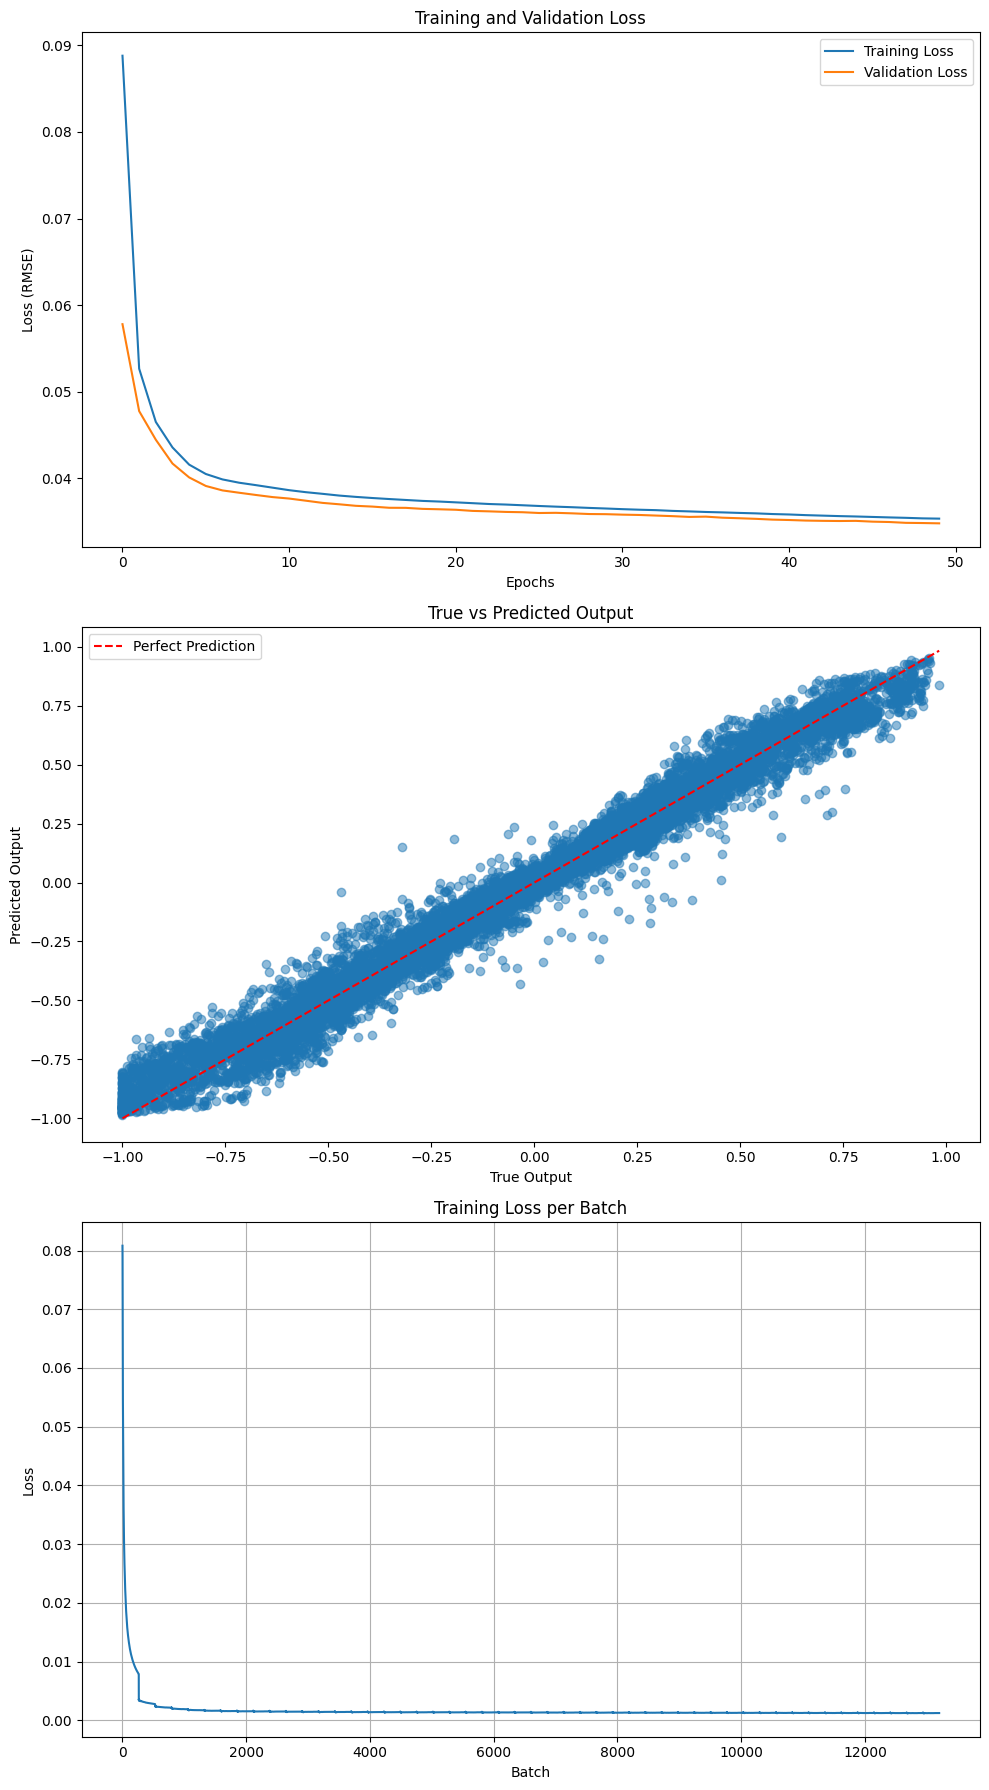

In [14]:
# Create one figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot 1: Training and Validation Loss
axs[0].plot(np.sqrt(history.history['loss']), label='Training Loss')
axs[0].plot(np.sqrt(history.history['val_loss']), label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss (RMSE)')
# axs[0].set_ylim([0.001, 0.005])
axs[0].legend()

# Plot 2: True vs Predicted Output
y_pred = model.predict([X_FB_test, X_FF_test])
axs[1].scatter(y_test, y_pred, alpha=0.5)
axs[1].set_title('True vs Predicted Output')
axs[1].set_xlabel('True Output')
axs[1].set_ylabel('Predicted Output')
axs[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
axs[1].legend()

# Plot 3: Batch Loss
axs[2].plot(batch_loss_logger.batch_losses)
axs[2].set_title('Training Loss per Batch')
axs[2].set_xlabel('Batch')
axs[2].set_ylabel('Loss')
axs[2].grid(True)
# axs[2].set_ylim([0.001, 0.002])

plt.tight_layout()
plt.show()

In [15]:
# Export the model
model.export("SteeringModel_Iteration97")

INFO:tensorflow:Assets written to: SteeringModel_Iteration97\assets


INFO:tensorflow:Assets written to: SteeringModel_Iteration97\assets


Saved artifact at 'SteeringModel_Iteration97'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_feedback'), TensorSpec(shape=(None, 3), dtype=tf.float32, name='input_feedforward')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1751030146128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751030151120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1750990640080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751030144976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751030151696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751030150352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751030144592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751030145360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751030149584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1751030147856: TensorS